# Random Sampling an Approximate Subset Size of Distinct Items from a Population

Random sampling (Bernoulli sampling) is a type of probability sampling in which an unbiased subset of items are selected from a population. Essentially assigning each item a random number between $0$ and $1$ and either selecting a subset from the top of the population (after sorting by the random number), or including the item if it falls under the chosen threshold in a streaming context.

We are interested in what threshold to use to obtain a subset of specific (approximate) size. Furthermore if our population contains duplicate items, how does this affect our choice of threshold, so that we are still able to obtain a unique/distinct subset of specific (approximate) size.

## Bernoulli Sampling - Unique (No Duplicates) Population

*Where the popultion contains no duplicates, or duplicates are not taken into account.*

In [Bernoulli sampling](https://en.wikipedia.org/wiki/Bernoulli_sampling) each item of the population is subjected to an independent Bernoulli trial which determines whether the item becomes part of the sample. An essential property of Bernoulli sampling is that all elements of the population have equal probability of being included in the sample.

Because each element of the population is considered separately for the sample, the sample size is not fixed but rather follows a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Where the probability of getting exactly $k$ successes in $n$ independent Bernoulli trials, with the same probability ($p$), is given by:

$$
P(X=k) = {n \choose k} \, p^k \, (1-p)^{n-k}
$$

for $k=0,1,2,...,n$.

The expected value (mean), which we are interested in as the approximate subset size, is given by: $\mathbb{E}[X] = np$

To illustrate Bernoulli sampling, suppose we have a population of $1\,000\,000$ unique items, and we are looking to sample a subset of approximately $10\,000$ items. We use the formula for the expected value of the binomial distribution to obtain the threshold:

$$
\mathbb{E}[X] = np
$$
$$
10\,000 = 1\,000\,000 p
$$
$$
p = \frac{10\,000}{1\,000\,000}
$$
$$
p = 0.01
$$

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

def sample(population : list[int], p : float) -> int:
    subset = set()
    for item in population:
        if random.random() < p:
            subset.add(item)
    return len(subset)

def sample_distribution(population : list[int], p : float) -> None:
    sample_sizes = [sample(population, p) for i in range(2_500)]

    print(f'Mean: {np.mean(sample_sizes):.2f}, Standard Deviation: {np.std(sample_sizes):.2f}')

    plt.hist(sample_sizes, bins=25, align='left', density=True)
    plt.axvline(x=np.mean(sample_sizes), linestyle='dashed', color='r', label='mean')
    plt.legend()
    plt.show()


In [2]:
unique_population = list(range(1_000_000))
unique_freq = np.bincount(unique_population)

Mean: 9999.00, Standard Deviation: 99.50


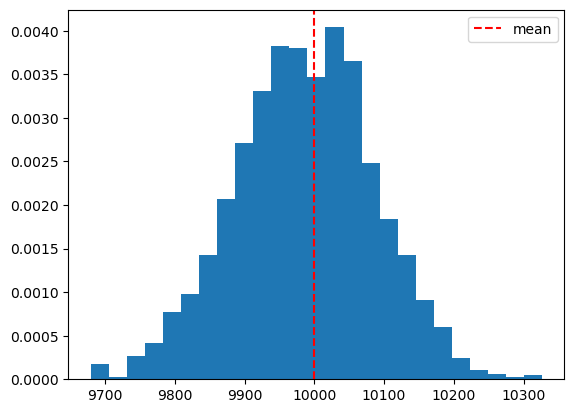

In [3]:
sample_distribution(unique_population, 0.01)

Confirming that the threshold ($0.01$) obtained from the expected value formula, does indeed produce an approximate subset of size $10\,000$.

## Distinct Random Sampling (Population contains Duplicates)

To illustrate the problem, we are still looking to sample an subset of size approximately $10\,000$, from a population of $1\,000\,000$. But with the further complication of the population containing only $200\,000$ unique items.

We consider two populations, the first where the duplicates are uniformly distributed (there is exactly $5$ of each item in the population), as well as a skew distribution, where a few items consist of most of the duplicates.

We start off by running the same experiment as done for the unique population, sampling with a threshold of $0.01$.

### Uniformly Distributed Duplicates

In [4]:
n = 1_000_000
u = 200_000

uniform_population = list(range(u)) * ( n // u )
uniform_freq = np.bincount(uniform_population)
random.shuffle(uniform_population)

assert len(uniform_population) == n
assert len(set(uniform_population)) == u

Mean: 9798.67, Standard Deviation: 93.52


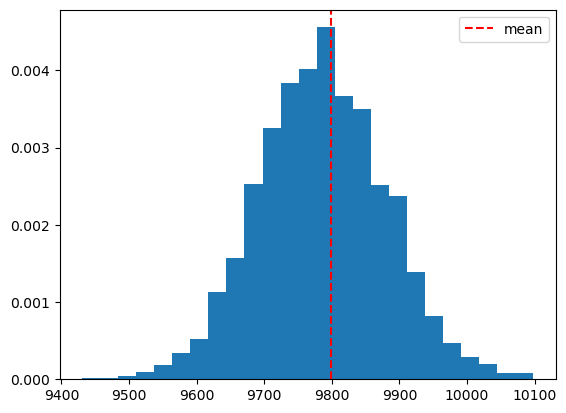

In [5]:
sample_distribution(uniform_population, 0.01)

Falling slightly short, but coming quite close. Indicating that only a slight amount of oversampling would be needed.

### Skewed Distribution of Duplicates

In [6]:
n = 1_000_000
u = 200_000

p_skew = 0.005
skew_freq = []
for k in range(1, u + 1):
    skew_freq.append( ( (1 - p_skew)**(k - 1) ) * p_skew )

skew_freq = np.round(( np.array(skew_freq) * (n - u) ) + 1).astype(int)

to_add = np.zeros_like(skew_freq)
for i in range(int(n - np.sum(skew_freq))):
    to_add[i] = 1

skew_freq += to_add

skew_population = []
for i in range(len(skew_freq)):
    skew_population.extend([i] * skew_freq[i])

random.shuffle(skew_population)

assert len(skew_population) == n
assert len(set(skew_population)) == u

Sorted from largest to smallest, the plot of the first $5\,000$ illustrates the frequence distribution.

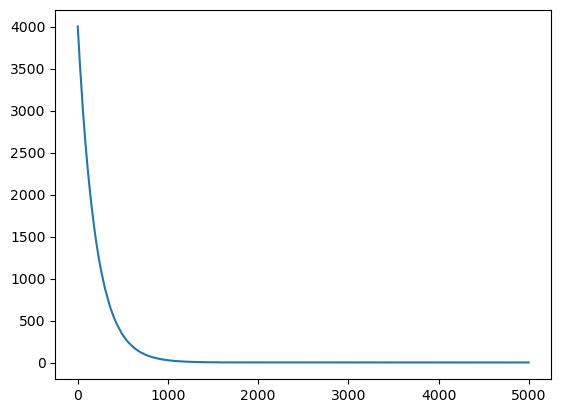

In [7]:
plt.plot(skew_freq[:5000])
plt.show()

Mean: 2842.77, Standard Deviation: 46.06


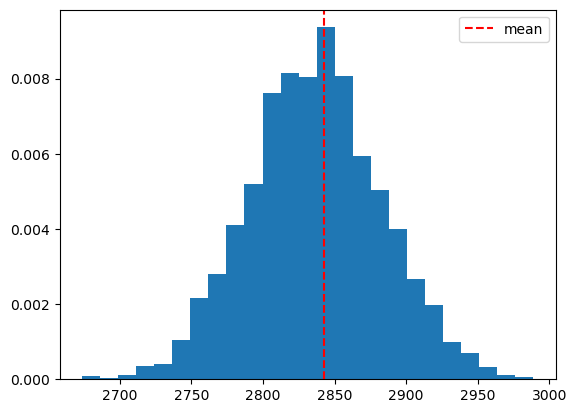

In [8]:
sample_distribution(skew_population, 0.01)

Unlike the uniform distribution, using a treshold of $0.01$ for this population completely undersamples unique items.

### Finding the Correct Threshold

As we have seen, we need to use a different threshold when sampling from a population that contains duplicates, that is dependent on the distribution of the duplicates (frequency of the items in the population).

To achieve this we have to consider a [Poisson binomial distribution](https://en.wikipedia.org/wiki/Poisson_binomial_distribution), which allows for our scenario of independent Bernoulli trials that are not identically distributed.

The expected value (mean) of the Poisson binomial distribution is given by:

$$
\mathbb{E}[X] = \sum_{i=1}^{n} p_i
$$

*Note that this is equal to the binomial distribution when the probabilities of selecting each item is identical, as with the unique population.*

To compute the threshold, in order to obtain the required approximate subset size (expected value), we will obtain the probability of selecting each unique item in a population individually, with the same threshold ($p$), using the binomial distribution.

As input to the Poisson binomial; for each unique item, given the item frequency in the population, we want to compute $P(\text{at least one})$. The probability that at least one of the duplicate items in question are chosen. Which we calculate as $P(\text{at least one}) = 1 - P(\text{zero})$, or the probability of not sampling zero of the item in question. Which can easily be calculated using the probability mass function of the binomial distribution, where $f$ specifies the frequency or amount of duplicates for the item:

$$
P(\text{zero}) = {f \choose 0} \, p^0 \, (1-p)^{f - 0}
$$
$$
P(\text{zero}) = (1-p)^f
$$
$$
P(\text{at least one}) = 1 - (1-p)^f
$$

Where the threshold ($p$) is the same for each item, we compute the expected value as:

$$
\mathbb{E}[X] = \sum_{i=1}^{u} P(\text{at least one})_i
$$

over the set of unique items ($u$).

To obtain the threshold ($p$) to use to obtain an approximate subset size, we use a form of binary search to narrow down $p$ to get close to the subset size, as follows:

In [9]:
def expected_value(p : float, item_freq : list[int]) -> int:
    out = 0
    for f in item_freq:
        out += 1 - (1 - p)**f
    return out

def find_threshold(E : int, freq : list[int], low : float, high : float) -> None:
    for _ in range(20):
        mid = low + ( ( high - low ) / 2 )
        tup = expected_value(low, freq), expected_value(mid, freq), expected_value(high, freq)
        if tup[0] < E and E < tup[1]:
            high = mid
        else:
            low = mid
    print(f'Final Expected: {tup[0]:.2f}, p: {mid}')

To verify that it still works, though very ineffective, for the unique population.

In [10]:
find_threshold(10_000, unique_freq, low=0.005, high=0.5)

Final Expected: 9999.21, p: 0.009999680519104003


We obtain the threshold for the uniformly distributed population.

In [11]:
find_threshold(10_000, uniform_freq, low=0.005, high=0.5)

Final Expected: 9999.77, p: 0.010206446647644044


Mean: 9997.75, Standard Deviation: 99.05


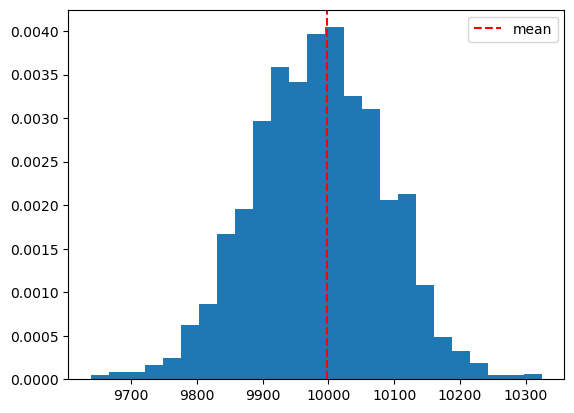

In [13]:
sample_distribution(uniform_population, 0.010206446647644044)

Verifying that the threshold does indeed provide the required subset size. As well as for the skew distribution, requiring us to oversample a lot more.

In [14]:
find_threshold(10_000, skew_freq, low=0.005, high=0.5)

Final Expected: 9999.83, p: 0.04450224399566652


Mean: 10001.38, Standard Deviation: 94.46


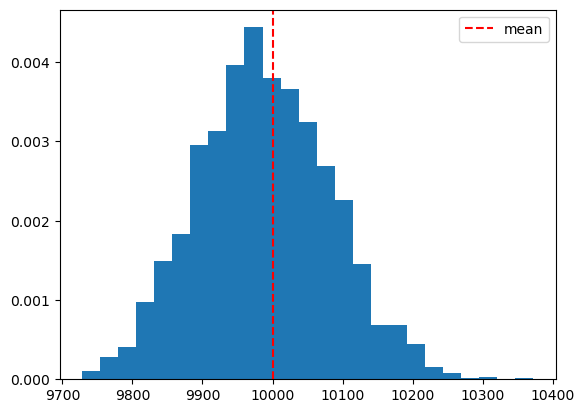

In [15]:
sample_distribution(skew_population, 0.04450224399566652)